In [1]:
import pyzx as zx
import random
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumCircuit, ParameterVector
import csv
import time
from typing import List,Dict,Set

In [2]:
def generate_H_S_CNOT_T_circuit(qubits, gates, p_t=0, seed=1000):
    random.seed(seed)  
    p_s = 0.333 * (1.0 - p_t)  
    p_had = 0.333 * (1.0 - p_t)  
    p_cnot = 0.333 * (1.0 - p_t)  

    c = zx.Circuit(qubits) 
    for _ in range(gates):
        r = random.random() 
        if r < p_had:
            c.add_gate("HAD", random.randrange(qubits))
        elif r < p_had + p_s:
            c.add_gate("S", random.randrange(qubits))
        elif r < p_had + p_s + p_t:
            c.add_gate("T", random.randrange(qubits))
        else:
            tgt = random.randrange(qubits)
            while True:
                ctrl = random.randrange(qubits)
                if ctrl != tgt:
                    break
            c.add_gate("CNOT", tgt, ctrl)
    return c



In [8]:
seed_list = [1,2,3,4,5]
qubit_list = [4,8,16]
gate_list = [100,1000,3000,5000,8000,10000]
p_t_lists = [i * 0.04 for i in range(0, 11)]

output_file = "./kekka1225/1225aa.csv"
fieldnames=["optimize_name","qubit","input_gates","p_t","seeds","H_edge","H + 2 qubit gates","H","2 qubit gates","gates_aft"]

with open(output_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for qubit in qubit_list:
        for gate_num in gate_list:
            for p_t in p_t_lists:
                for seed in seed_list:
                    try:
                        c = generate_H_S_CNOT_T_circuit(qubits = qubit,gates= gate_num,p_t = p_t,seed = seed)
                        c = zx.optimize.basic_optimization(c)
                        g = c.to_graph()
                        zx.simplify.clifford_simp(g)

                        #edge count
                        H_edge_count = 0
                        normal_edge_count = 0
                        for v0,adj in g.graph.items():
                            for v1 in adj:
                                if v1 > v0:
                                    if g.edge_type((v0,v1)) == 2:
                                        H_edge_count += 1
                                    else:
                                        normal_edge_count += 1
                        #print("H count" ,H_edge_count , "normal count", normal_edge_count)

                        #degree
                        degrees: dict[int,int] = {}
                        for v in g.vertices():
                            d = g.vertex_degree(v)
                            if d in degrees:
                                degrees[d] += 1
                            else:
                                degrees[d] = 1
                            degrees = dict(sorted(degrees.items()))
                        #print("jisaku degree",degrees)

                        #degree
                        degree1or2 = 0
                        degree2over = 0
                        for v in g.vertices():
                            d = g.vertex_degree(v)
                            if d == 1 or d == 2:
                                degree1or2 += 1
                            elif d > 2:
                                degree2over += 1

                        c = zx.extract.streaming_extract(g)
                        #c = zx.optimize.basic_optimization(c)

                        #qiskit変換とカウント
                        circuit_qiskit = QuantumCircuit.from_qasm_str(c.to_basic_gates().to_qasm())
                        depth = circuit_qiskit.depth()
                        zx_dict = c.to_basic_gates().stats_dict()
                        qiskit_dict = circuit_qiskit.count_ops()

                        optimize_name = "clifford_simp_not_post_basic"
                        gates_aft = zx_dict["gates"]



                        # 結果をCSVに書き込む
                        writer.writerow({
                            "optimize_name": optimize_name,
                            "qubit": qubit,
                            "input_gates": gate_num,
                            "p_t": p_t,
                            "seeds": seed,
                            "H_edge": H_edge_count,
                            "H + 2 qubit gates": qiskit_dict.get("h", 0) + qiskit_dict.get("cx", 0) + qiskit_dict.get("cz", 0),
                            "H": qiskit_dict.get("h", 0),
                            "2 qubit gates": qiskit_dict.get("cx", 0) + qiskit_dict.get("cz", 0),
                            "gates_aft": gates_aft
                        })

                        print(f"done. Qubits={qubit}, Gate_Num={gate_num}, P_T={p_t},seed={seed}")

                    except Exception as e:
                        print(f"Error for Qubits={qubit}, Gate_Num={gate_num}, P_T={p_t}: {e}")


This function is deprecated. Call extract_circuit() instead.
done. Qubits=4, Gate_Num=100, P_T=0.0,seed=1
This function is deprecated. Call extract_circuit() instead.
done. Qubits=4, Gate_Num=100, P_T=0.0,seed=2
This function is deprecated. Call extract_circuit() instead.
done. Qubits=4, Gate_Num=100, P_T=0.0,seed=3
This function is deprecated. Call extract_circuit() instead.
done. Qubits=4, Gate_Num=100, P_T=0.0,seed=4
This function is deprecated. Call extract_circuit() instead.
done. Qubits=4, Gate_Num=100, P_T=0.0,seed=5
This function is deprecated. Call extract_circuit() instead.
done. Qubits=4, Gate_Num=100, P_T=0.04,seed=1
This function is deprecated. Call extract_circuit() instead.
done. Qubits=4, Gate_Num=100, P_T=0.04,seed=2
This function is deprecated. Call extract_circuit() instead.
done. Qubits=4, Gate_Num=100, P_T=0.04,seed=3
This function is deprecated. Call extract_circuit() instead.
done. Qubits=4, Gate_Num=100, P_T=0.04,seed=4
This function is deprecated. Call extract_

Circuit  on 3 qubits with 25 gates.
        5 is the T-count
        20 Cliffords among which
        7 2-qubit gates (7 CNOT, 0 other) and
        5 Hadamard gates.
Circuit  on 3 qubits with 13 gates.
        1 is the T-count
        12 Cliffords among which
        5 2-qubit gates (5 CNOT, 0 other) and
        2 Hadamard gates.


Graph(12 vertices, 12 edges)
degree distribution: 
1: 6
2: 2
3: 2
4: 2

H count 8 normal count 4
jisaku degree {1: 6, 2: 2, 3: 2, 4: 2}
phase count 4
This function is deprecated. Call extract_circuit() instead.
Circuit  on 3 qubits with 12 gates.
        1 is the T-count
        11 Cliffords among which
        3 2-qubit gates (0 CNOT, 3 other) and
        5 Hadamard gates.


gate_count OrderedDict([('h', 5), ('rz', 4), ('cz', 3)])


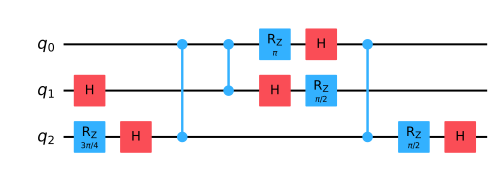

In [227]:
c = generate_H_S_CNOT_T_circuit(3,gates=25,p_t=0.2, seed = 11)
print(c.stats())
c = zx.optimize.basic_optimization(c)
print(c.stats())

g = c.to_graph()
zx.draw(g)


zx.simplify.clifford_simp(g)
zx.draw(g)
print(g.stats())

#edge count
H_edge_count = 0
normal_edge_count = 0
for v0,adj in g.graph.items():
    for v1 in adj:
        if v1 > v0:
            if g.edge_type((v0,v1)) == 2:
                H_edge_count += 1
            else:
                normal_edge_count += 1
print("H count" ,H_edge_count , "normal count", normal_edge_count)

#degree
degrees: dict[int,int] = {}
for v in g.vertices():
    d = g.vertex_degree(v)
    if d in degrees:
        degrees[d] += 1
    else:
        degrees[d] = 1
    degrees = dict(sorted(degrees.items()))
print("jisaku degree",degrees)

#phase_count
phase_count = 0
for v in g.vertices():
    if g.phase(v) != 0:
        phase_count += 1
print("phase count", phase_count)

#for v in g.vertices():
    #H_edgeの次数を調べる
    

#g2 = g.clone()

c = zx.extract.streaming_extract(g,quiet=True)
#c = zx.extract_circuit(g,optimize_cnots=0,optimize_czs=False)

#c = zx.optimize.basic_optimization(c)
print(c.stats())
zx.draw(c)

circuit_qiskit = QuantumCircuit.from_qasm_str(c.to_basic_gates().to_qasm())

print("gate_count", circuit_qiskit.count_ops())
circuit_qiskit.draw('mpl')

In [181]:
print(g2.graph.items())
g3 = g2.clone()
print(g3.edge_set())
#g3.remove_edge((3,4))
g3.remove_edges([(3,4),(14,16),(4,21),(11,21),(14,19),(14,22)])
zx.draw(g3)

dict_items([(0, {3: 1}), (1, {4: 2}), (2, {12: 2}), (3, {0: 1, 4: 2, 9: 2}), (4, {1: 2, 3: 2, 21: 2, 14: 2}), (9, {16: 2, 3: 2, 22: 2}), (11, {12: 2, 21: 2}), (12, {11: 2, 2: 2, 21: 2, 14: 2}), (14, {19: 2, 4: 2, 12: 2, 16: 2, 22: 2, 30: 2}), (16, {9: 2, 24: 2, 21: 2, 14: 2}), (19, {21: 2, 14: 2, 25: 2}), (21, {19: 2, 4: 2, 12: 2, 16: 2, 30: 2, 11: 2}), (22, {26: 2, 9: 2, 14: 2}), (24, {16: 2}), (25, {19: 2}), (26, {22: 2}), (29, {30: 2}), (30, {29: 2, 21: 2, 14: 2})])
{(3, 4), (14, 16), (4, 21), (14, 19), (22, 26), (14, 22), (19, 21), (3, 9), (4, 14), (12, 21), (21, 30), (9, 16), (14, 30), (9, 22), (16, 21), (16, 24), (12, 14), (29, 30), (0, 3), (1, 4), (11, 12), (19, 25), (2, 12), (11, 21)}


This function is deprecated. Call extract_circuit() instead.


Exception: No extractable vertex found. Something went wrong

In [37]:
c = generate_H_S_CNOT_T_circuit(4,gates=100,p_t=0.5, seed = 1000)
print(c.stats())
c = zx.optimize.basic_optimization(c)
print(c.stats())

g = c.to_graph()


zx.simplify.clifford_simp(g)

#graph から　H edgeの数を数える

print(g.stats())
zx.draw(g)
H_edge_count = 0
for v0,adj in g.graph.items():
    for v1 in adj:
        if v1 > v0:
            if g.edge_type((v0,v1)) == 2:
                H_edge_count += 1
print("H count" ,H_edge_count)

Circuit  on 4 qubits with 100 gates.
        52 is the T-count
        48 Cliffords among which
        17 2-qubit gates (17 CNOT, 0 other) and
        15 Hadamard gates.
Circuit  on 4 qubits with 44 gates.
        6 is the T-count
        38 Cliffords among which
        19 2-qubit gates (17 CNOT, 2 other) and
        9 Hadamard gates.
Graph(21 vertices, 34 edges)
degree distribution: 
1: 8
3: 4
4: 2
5: 3
6: 3
7: 1



H count 28
